In [3]:
import numpy as np
import pandas as pd 
import os

import matplotlib.pyplot as plt

Run these to get the gridded data

In [15]:
# Data file names

grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

#There are mov files for different datas, I'll add all of them here latter 
movs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_GRELHA E EIXOS")
movs_2022_09 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv")
movs_2022_10 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv")
movs_2022_11 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv")


In [16]:
df_movs_2022_09= pd.read_csv(movs_2022_09)
df_movs_2022_10= pd.read_csv(movs_2022_10)
df_movs_2022_11= pd.read_csv(movs_2022_11)

In [17]:
#Checking if we can just concatanate the 3 datasets...
print('2022_09 start time: ',df_movs_2022_09['Datetime'].min(),'\n',
'2022_09 end time: ',df_movs_2022_09['Datetime'].max(),'\n',
'2022_10 start time: ',df_movs_2022_10['Datetime'].min(),'\n',
'2022_10 end time: ',df_movs_2022_10['Datetime'].max(),'\n',
'2022_11 start time: ',df_movs_2022_11['Datetime'].min(),'\n',
'2022_11 end time: ',df_movs_2022_11['Datetime'].max())


2022_09 start time:  2022-09-01T00:00:00.000Z 
 2022_09 end time:  2022-09-30T23:45:00.000Z 
 2022_10 start time:  2022-10-01T00:00:00.000Z 
 2022_10 end time:  2022-10-31T23:45:00.000Z 
 2022_11 start time:  2022-11-01T00:00:00.000Z 
 2022_11 end time:  2022-11-30T23:45:00.000Z


In [18]:
# Join the 3 months' dataframes:

df_movs = pd.concat([df_movs_2022_09, df_movs_2022_10, df_movs_2022_11])
del(df_movs_2022_09, df_movs_2022_10, df_movs_2022_11)



In [19]:
# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['latitude', 'longitude', 'grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# coordinates
lats = dfs_grid_filtered['latitude'].values
lons = dfs_grid_filtered['longitude'].values
# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.zeros((grelha_y.max() +1, grelha_x.max()+1))
lat_2d = grelha_id_2d.copy()
lon_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

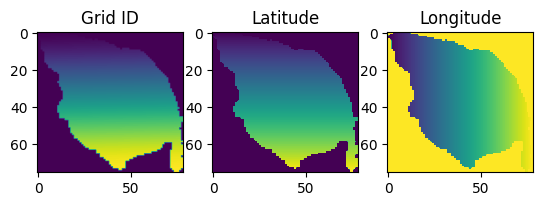

In [20]:
# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
lat_2d[tuple(idx_2d)] = lats.ravel()
lon_2d[tuple(idx_2d)] = lons.ravel()

fig, axs = plt.subplots(1,3)

axs[0].set_title('Grid ID')
axs[0].imshow(grelha_id_2d)

axs[1].set_title('Latitude')
axs[1].imshow(lat_2d, vmax = lats.max(), vmin = lats.min())

axs[2].set_title('Longitude')
axs[2].imshow(lon_2d, vmax = lons.max(), vmin = lons.min())



In [21]:
dfs_movs = [y for x, y in df_movs.groupby('Grid_ID', as_index=False)]

df_movs['Datetime'] = pd.to_datetime(df_movs['Datetime'])
dfs_movs_ordered = [dfs_movs[i].set_index('Datetime').sort_index() for i in range(len(dfs_movs))]
del(df_movs)
del(dfs_movs)

In [25]:
# This was to check if each cell id had the same missing timeStamps, since it would allow for a simpler implementation

missing_time_stamps_old = pd.date_range(dfs_movs_ordered[0].index.min(), dfs_movs_ordered[0].index.max(), freq='15min').difference(dfs_movs_ordered[0].index)
for id in range(len(dfs_movs_ordered)):
    missing_time_stamps = pd.date_range(dfs_movs_ordered[id].index.min(), dfs_movs_ordered[id].index.max(), freq='15min').difference(dfs_movs_ordered[id].index)
    same_missing_values = len(missing_time_stamps_old.difference(missing_time_stamps)) == 0 and len(missing_time_stamps_old) == len(missing_time_stamps)
    if not same_missing_values:
        break
    missing_time_stamps_old = missing_time_stamps                                       

if same_missing_values:
    print("Same missing timeStamps ... :)")
else:
    print(f"There are different missing timestamps between cells ... Stoppped in cell {id}")

# Since the mising time stamps are not exactly the same, it will be necessary to loop throug it
# in order to fill the data with the missing ones


NameError: name 'dfs_movs_ordered' is not defined

In [ ]:

# Function to check if a given dataset has no missing timeStamps

# To use the function, one of the coordinates should be the timeStamp, grid_id and dateTime should not be mixed
# The expected input is a list of dataframes

def fill_dataset(dataset_list, fill_method='nan'):
    """

    Args:
    dataset_list (list):
    fill_method (str): either 'nan' or 'interpolated'
    """

    df_complete = list()

    for dataframe in dfs_movs_ordered:
        missing_time_stamps = pd.date_range(dataframe.index.min(), dataframe.index.max(), freq='15min').difference(dataframe.index)
        missing_values = dataframe.iloc[0:len(missing_time_stamps),:].copy()
        if fill_method == 'nan':
            missing_values.loc[:,:] = np.NaN
        elif fill_method == 'interpolated':
            # Still have to implement this one in the next commit ...
            raise(NotImplemented)
        else: 
            raise('Invalid Option')
        df_complete.append(pd.concat([dataframe, missing_values]).sort_index())

    return df_complete



In [24]:
df_complete = fill_dataset(dfs_movs_ordered, fill_method='nan')
del(dfs_movs_ordered)

In [26]:
nTimeStamps = len(df_complete[0].index)
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)
lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)


In [27]:
# Construct the dataset with the right dimensions

nTimeStamps = len(df_complete[0].index)
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)

lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)

C1_grid = np.zeros_like(grelha_id_3d)
C2_grid = np.zeros_like(grelha_id_3d)
C3_grid = np.zeros_like(grelha_id_3d)
C4_grid = np.zeros_like(grelha_id_3d)
C5_grid = np.zeros_like(grelha_id_3d)
C6_grid = np.zeros_like(grelha_id_3d)
C7_grid = np.zeros_like(grelha_id_3d)
C8_grid = np.zeros_like(grelha_id_3d)

In [31]:
for id in np.unique(grelha_id):
    try:
        mask = grelha_id_3d[...,0] == id
        C1_grid[mask] = df_complete[id]['C1']
        C2_grid[mask] = df_complete[id]['C2']
        C3_grid[mask] = df_complete[id]['C3']
        C4_grid[mask] = df_complete[id]['C4']
        C5_grid[mask] = df_complete[id]['C5']
        C6_grid[mask] = df_complete[id]['C6']
        C7_grid[mask] = df_complete[id]['C7']
        C8_grid[mask] = df_complete[id]['C8']
    except:
        print(f'Grid element with id {id} not being assigned!')

del(df_complete)

# Full array of data:
data = np.stack([grelha_id_3d, lat_3d, lon_3d, C1_grid, C2_grid, C3_grid, C4_grid, C5_grid, C6_grid, C7_grid, C8_grid], axis = -1)

# The shape should be (y,x,timeStamp,var)
data.shape

Grid element with id 3743 not being assigned!


(76, 79, 8736, 11)

In [32]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

In [33]:
# Save data the data array:
# Currently takes 4.6GB
with open(grid_path, 'wb') as f:
    np.save(f, data)

Run this to load the gridded data if already available

In [19]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

**Plot a picture of all values**

In [39]:
def plot_picture(grid_data, timestamp_index, var):
    plt.figure()
    plt.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
    plt.show()
    plt.close()

In [40]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

In [41]:
data.shape

(76, 79, 2880, 11)

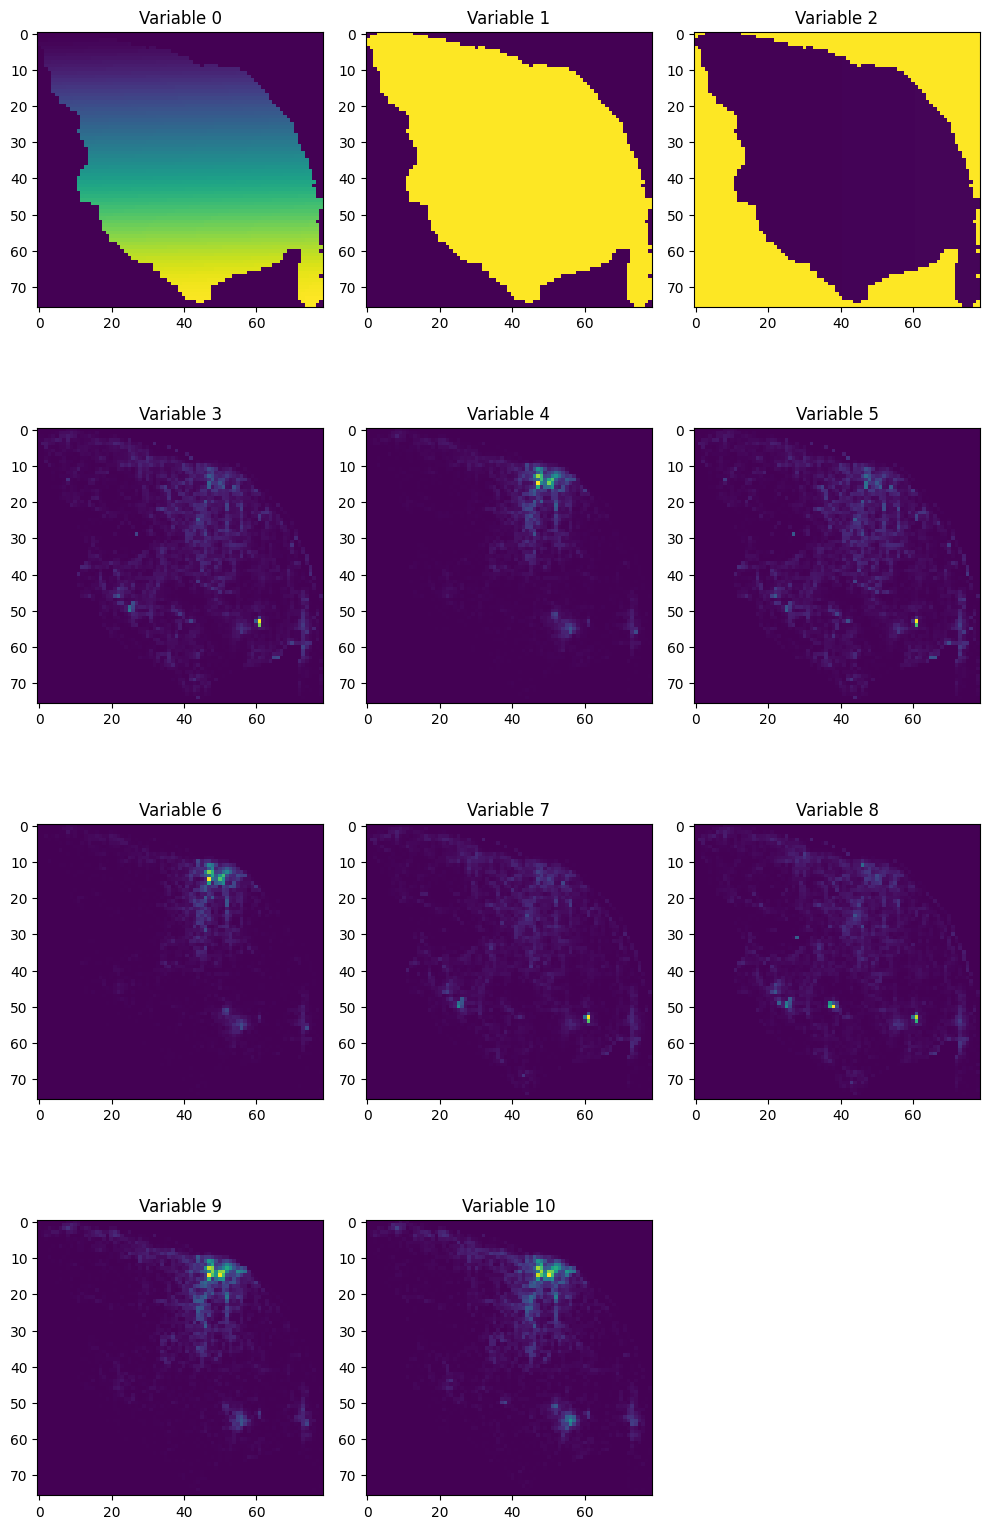

In [42]:
fig = plot_picture(grid_data = data, timestamp_index = 1000)